In [54]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sg

chi_ori = pd.read_csv('Chicago_Traffic_Crashes.csv')
road_ori = gpd.read_file('geo_export_aea9043d-42d5-45b7-a783-8892b91c499b.shp')

### Create the boundary of Chicago & trim the roads out side of the boundary ###
#bound = gpd.read_file('geo_export_39e46b3a-b112-4596-befe-69ddbae4a0bb.shp')
#bou = bound.geometry[0]  # turn this gpd file into a polygon/multi-poligon #
#chiroads = road[road.geometry.within(bou)]  

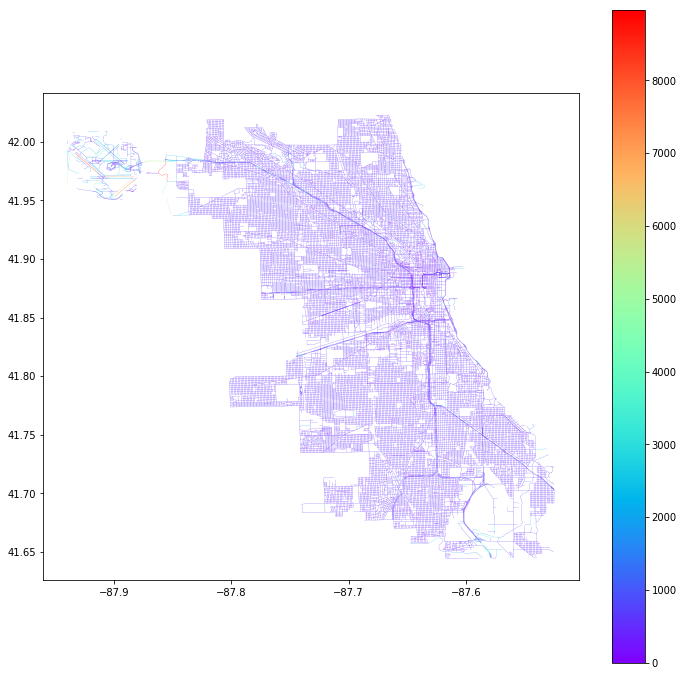

In [53]:
#road_ori.plot(figsize=(12,12), column='length', cmap='rainbow', legend =True, linewidth=0.2)

In [86]:
### Data preparation ###

chi = chi_ori[pd.notnull(chi_ori['LATITUDE'])]                 # delete all NaN values in Lat and lon #
chi = chi[pd.notnull(chi_ori['INJURIES_NO_INDICATION'])]   # delete all NaN values in INDICATION #
chi = chi[(chi[['LATITUDE','LONGITUDE']] != 0).all(axis=1)]
chi = chi[(chi[['INJURIES_NO_INDICATION']] < 100).all(axis=1)]   # select injury indication under 5 #
chi = chi.sort_values('LATITUDE', ascending=True)

road_ori = road_ori[pd.notnull(road_ori['geometry'])]

### Check the column lists of the pd/gpd file #
#chi.columns.values.tolist()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [87]:
### Define The Projection System ###

WGS84 = {'init': 'epsg:4326'}
NZTM = {'no_defs': True, 'init':'epsg:2193'}
Mercator ={'init': 'epsg:3395'}

road = road_ori.to_crs(WGS84)   # set the road network data to WGS84 system #

In [88]:
### Form Shapes: Condition 1_dedicated columns with shapes, e.g. POINT(_,_). 

#chicrash = gpd.GeoDataFrame(chi, crs=WGS84) # Change shapes into objects in GeoSeries, remember to set geometry as geometry #
#chicrash = chicrash.rename(columns={'LOCATION':'geometry'}) # Change LOCATION to geometry #
#chicrash = chicrash.set_geometry('geometry')

#chicrash.columns.values.tolist() # list the column names of the gpd file # 
#chicrash.head() # Check the contents of first rows#

In [89]:
### Form Shapes: Condition 2_Seperate Lat+Lon Data ###
### We use these codes here in this condition ###

geometry = [sg.Point(p) for p in zip(chi['LONGITUDE'],chi['LATITUDE'])] # Complie to shapes and creat a geometry column #
chicrash = gpd.GeoDataFrame(chi, crs=WGS84, geometry=geometry) # Change shapes into objects in GeoSeries, remember to set geometry as geometry

# Drop of the redundant column #
# the reason to drop LOCATION here is that the original 
# data contains a GeoSeries column LOCATION, which conflicts 
# with the newly generated one 

chicrash.drop(columns='LOCATION', axis=1, inplace=True) 

#chicrash.columns.values.tolist() # list the column names of the gpd file # 
#chicrash.head() # Check the contents of first rows#

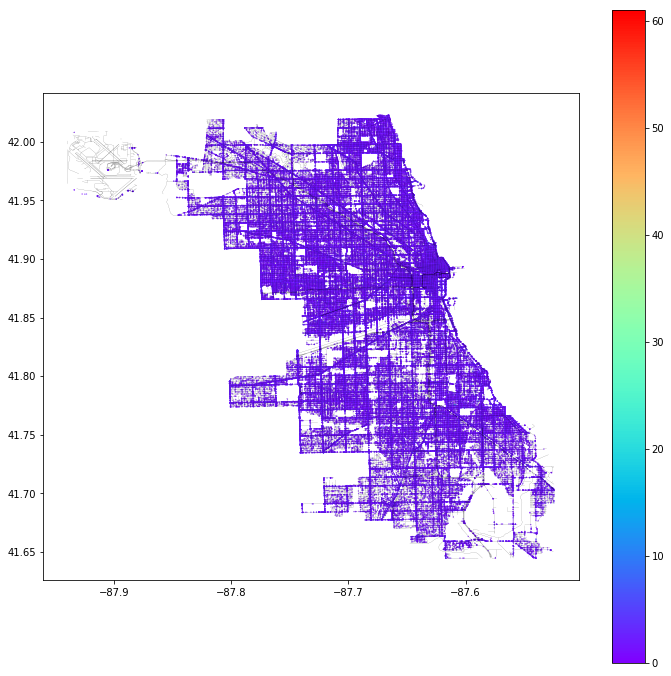

In [90]:
### Plot the crash data as figures ###

f, ax = plt.subplots(1, figsize=(12, 12))
base = road.plot(color='black', ax=ax, linewidth = 0.1)
chicrash.plot(ax=base,column='INJURIES_NO_INDICATION', markersize = 0.1, legend=True, cmap='rainbow')
plt.show()

In [91]:
#road.columns.values.tolist()
#road.head(10)

In [92]:
### create buffer zones of crashes ###

# Buffer the POINTs #
b_size = 0.0005  # generate buffer with 0.001 units (probably not in meters)
cra = chicrash[['geometry', 'INJURIES_NO_INDICATION']]
cra['geometry'] = cra['geometry'].buffer(b_size)
#cra.plot(figsize=(12,12))

# Buffer the POINTs #
rd = road[['geometry', 'objectid', 'length', 'streetname']]
inter = gpd.sjoin(rd, cra, how='inner', op='intersects')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


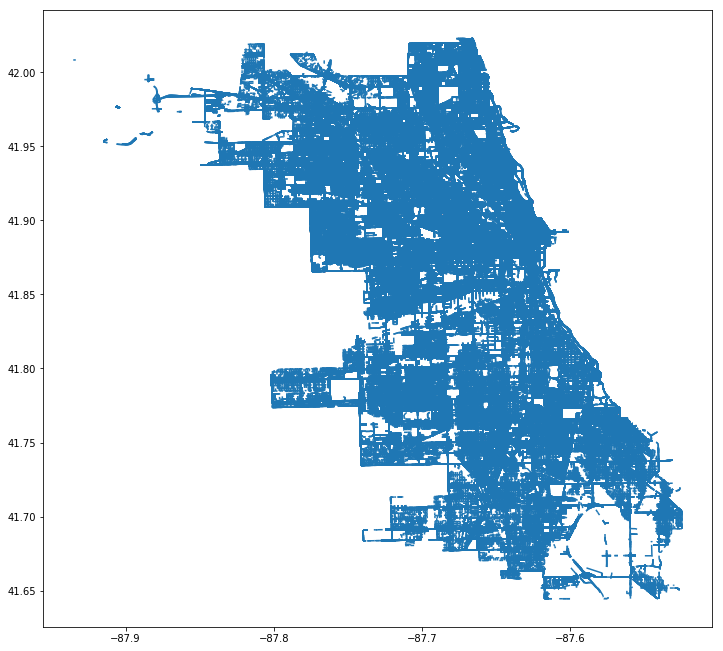

In [93]:
inter.plot(figsize=(12,12),legend=True)

In [94]:
inter.columns.values.tolist()

['geometry',
 'objectid',
 'length',
 'streetname',
 'index_right',
 'INJURIES_NO_INDICATION']

In [95]:
 ###  Assign crash accidents number yo road ###
    
inter['crash_num'] = 1
crashmap = inter.groupby('objectid', as_index=False).agg({
  'crash_num': 'sum',
  'streetname': 'first',
  'geometry': 'first',
  'index_right': 'first',
  'length': 'first',
  'INJURIES_NO_INDICATION': 'first'
  })
crashmap = gpd.GeoDataFrame(crashmap, crs=WGS84)
crashmap['crash_risk'] = crashmap['crash_num']/crashmap['length']
crashmap['casulty_risk'] = crashmap['INJURIES_NO_INDICATION']/crashmap['length']

In [101]:
#crashmap.sort_values('crash_num', ascending=False)
#print(crashmap.describe())

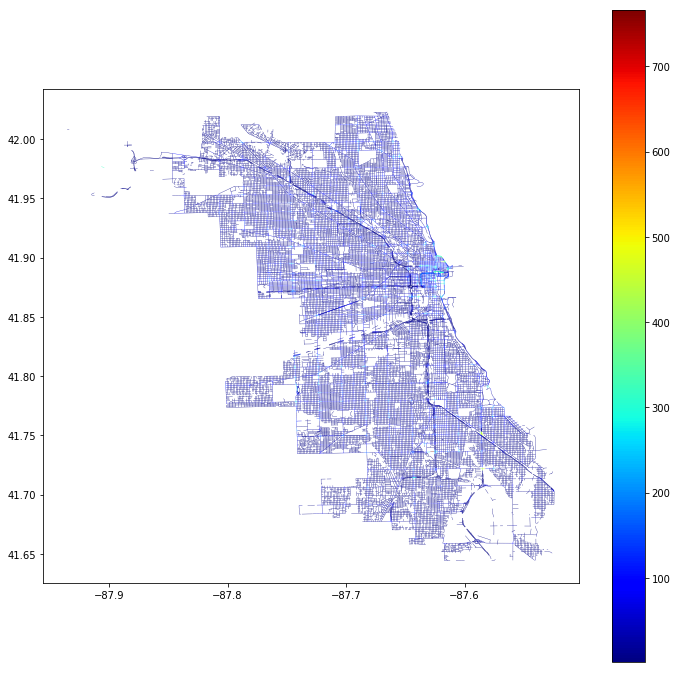

In [100]:
crashmap.plot(figsize=(12,12),column='crash_num', cmap='jet', legend=True, linewidth=0.3)

In [123]:
### Plot on Folium ###
import spectra

# Use Colorbrewer spectral colors
colors = reversed(['#ccff99', '#5c66eb','#8566d6','#ad66c2','#ff6699','#000099'])  
cuts = [0] + [crashmap['crash_num'].quantile(i/100) for i
              in [20,40,60,80,100]]
scale = spectra.scale(colors).colorspace('lch').domain(cuts)
crashmap['color'] = crashmap['crash_num'].map(lambda x: scale(x).hexcode)


In [136]:
import folium
import json

crashmap = crashmap.to_crs(WGS84) 
lon, lat = crashmap.geometry.iat[0].coords[0]  # Center on crashiest road
til = 'https://basemaps.net.png'
mapp = folium.Map(location=[lat, lon], zoom_start=12,fill_color='YlGnBu',highlight=True,legend_name='crash_num_legend')


def style(x):
    return {'color': x['properties']['color'],'weight':2.5}

geo = json.loads(crashmap.sort_values('crash_num').to_json())
folium.GeoJson(geo,style_function=style).add_to(mapp)
mapp.save('plot_crash_map.html')

from IPython.display import HTML
HTML('<iframe src=plot_crash_map.html width=1000 height=600></iframe>')

In [134]:
import folium
import json


layer_1= folium.features.Choropleth(
    geo_data= crashmap
    ,name= 'crash_num'
    ,key_on='geometry'
    ,columns= ['geometry', 'crash_num']
    ,fill_color='YlGnBu'
    ,highlight=True
    ,legend_name='crash_num_legend'
    )
# popup window
tooltip_1= folium.features.GeoJsonTooltip(['geometry', 'crash_num'])
layer_1.geojson.add_child(tooltip_1) # add it to the layer
mapp.save('plot_crash_map2.html')

from IPython.display import HTML
HTML('<iframe src=plot_crash_map2.html width=1000 height=600></iframe>')